# Blaseball ELO System
## By @BirdWife#7151 [@Birdwife_](https://www.twitter.com/BirdWife_)

Are Crabs Good? Let's find out using Elo!

A player's new rating after a tournament is calculated :

Rn = Ro + (K/2)(W - L + (Sum of rating differences/2C))
Rn is the new rating, Ro is the old rating. W and L are the number of wins and losses. A rating difference is the opponent's rating minus the player's rating, not the other way around.

C will determine how spaced out the ratings are, i.e. the standard deviation. It appears that 200 is commonly used.

K will determine how much of an effect each game has. FIDE uses 30, and 20 once a player reaches IM. http://www.fide.com/component/content/article/1-fide-news/3963-rating-regulations-the-k-factor

A draw is 0 wins and 0 losses.


Elo devised a linear approximation to his full system. With that method, a player's new rating is

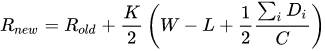

where Rnew and Rold are the player's new and old rating respectively, Di is the opponent's rating minus the player's rating, W is the number of wins, L is the number of losses, C = 200 and K = 32.



In [37]:
# Imports and globals

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns=None
pd.options.display.max_rows=None

sns.set_style('darkgrid')

#### Getting and saving our game data

In [38]:
req = requests.get(f'https://api.sibr.dev/chronicler/v1/games')

In [39]:
x = req.json()

In [40]:
games = pd.json_normalize(x['data'])

In [41]:
games.to_csv('./data/games.csv',index=False)

#### Exploring to ensure we have what we need

In [42]:
games.head()

gameId                    startTime  \
0  5947b5f0-7a90-4896-bfa6-fd011a36fba7  2020-11-17T22:00:02.891029Z   
1  85ba2b4e-64ec-4ab4-8d68-a9951409aaab  2020-11-17T22:00:06.877036Z   
2  9e3111de-67ae-451e-864f-2f9ee8efb5c4  2020-11-17T22:00:02.891029Z   
3  c906cb01-3214-4d70-a953-e8575f4fb450  2020-11-17T22:00:02.891029Z   
4  caef7953-e9eb-4686-9f78-45271f7ed335  2020-11-17T22:00:06.877036Z   

                       endTime                               data.id  \
0  2020-11-17T22:25:23.190674Z  5947b5f0-7a90-4896-bfa6-fd011a36fba7   
1  2020-11-17T22:28:31.331468Z  85ba2b4e-64ec-4ab4-8d68-a9951409aaab   
2  2020-11-17T22:20:47.009897Z  9e3111de-67ae-451e-864f-2f9ee8efb5c4   
3  2020-11-17T22:25:59.324029Z  c906cb01-3214-4d70-a953-e8575f4fb450   
4  2020-11-17T22:22:19.021837Z  caef7953-e9eb-4686-9f78-45271f7ed335   

   data.day  data.phase                            data.rules  data.shame  \
0         0           6  4ae9d46a-5408-460a-84fb-cbd8d03fff6c       False   
1         0           6  4ae9d46a-5408-460a-84fb-cbd8d03fff6c       False   
2         0           6  4ae9d46a-5408-460a-84fb-cbd8d03fff6c       False   
3         0           6  4ae9d46a-5408-460a-84fb-cbd8d03fff6c       False   
4         0           6  4ae9d46a-5408-460a-84fb-cbd8d03fff6c       False   

   data.inning  data.season  data.weather  data.awayOdds  data.awayOuts  \
0            8           -1          15.0       0.509359            3.0   
1            8           -1          15.0       0.494244            3.0   
2            8           -1          15.0       0.536428            3.0   
3            8           -1          15.0       0.468413            3.0   
4            8           -1          15.0       0.483632            3.0   

                          data.awayTeam  data.homeOdds  data.homeOuts  \
0  4d921519-410b-41e2-882e-9726a4e54a6a       0.490641            3.0   
1  70eab4ab-6cb1-41e7-ac8b-1050ee12eecc       0.505756            3.0   
2  9e42c12a-7561-42a2-b2d0-7cf81a817a5e       0.463572            3.0   
3  3b0a289b-aebd-493c-bc11-96793e7216d5       0.531587            3.0   
4  d8f82163-2e74-496b-8e4b-2ab35b2d3ff1       0.516368            3.0   

                          data.homeTeam  \
0  49181b72-7f1c-4f1c-929f-928d763ad7fb   
1  a3ea6358-ce03-4f23-85f9-deb38cb81b20   
2  7fcb63bc-11f2-40b9-b465-f1d458692a63   
3  e3f90fa1-0bbe-40df-88ce-578d0723a23b   
4  4e5d0063-73b4-440a-b2d1-214a7345cf16   

                              data.outcomes  data.awayBalls  data.awayBases  \
0                                        []             4.0             4.0   
1                                        []             4.0             4.0   
2  [GM was Percolated by the Tractor Bean!]             4.0             4.0   
3                                        []             4.0             4.0   
4                                        []             4.0             4.0   

   data.awayScore  data.finalized  data.gameStart  data.homeBalls  \
0             4.0            True            True             4.0   
1            12.0            True            True             4.0   
2             0.0            True            True             4.0   
3             7.0            True            True             4.0   
4             4.5            True            True             4.0   

   data.homeBases  data.homeScore  data.playCount  \
0             4.0             9.0           277.0   
1             4.0             4.0           305.0   
2             4.0             4.0           246.0   
3             4.0             2.0           285.0   
4             4.0             2.5           262.0   

                         data.statsheet  data.atBatBalls data.awayBatter  \
0  824ea7be-18b3-496f-b731-1fa86c7b07f2                0            None   
1  24236312-3e9e-4bdb-a039-a5da0793deef                0            None   
2  f2a2b630-ced4-4ed2-b15d-04a5228ce612                0            None   
3  4d3a6538-5b5a-4081-9ee5-2fe16027f6b0   

#### Create an outcome flag and some cleaning to make things easier

In [43]:
# Drop coffee cup games
games = games[(games['data.season'] != 0) & (games['data.season'] != -1)]

# Outcome flags and nickname cleaning
games['data.awayTeamNickname'] = games['data.awayTeamNickname'].map(lambda x: 'Dale' if x == 'Dalé' else 'Wild Wings' if x == 'Mild Wings' else x)
games['data.homeTeamNickname'] = games['data.homeTeamNickname'].map(lambda x: 'Dale' if x == 'Dalé' else 'Wild Wings' if x == 'Mild Wings' else x)

winner = []
loser = []
for index, entry in games.iterrows():
    winner.append(entry['data.awayTeamNickname'] if entry['data.awayScore'] > entry['data.homeScore'] else entry['data.homeTeamNickname'])
    loser.append(entry['data.awayTeamNickname'] if entry['data.awayScore'] < entry['data.homeScore'] else entry['data.homeTeamNickname'])


games['winner'] = winner
games['loser'] = loser

# Incrementing day and season up 1 for clarity
games['data.day'] = games['data.day'].map(lambda x: x + 1)
games['data.season'] = games['data.season'].map(lambda x: x + 1)

# Removing games where scores are both zero

games = games[~(games['winner'] == games['loser'])]

In [44]:
games['winner'].value_counts()

Tigers           839
Moist Talkers    732
Crabs            720
Pies             706
Garages          704
Millennials      698
Shoe Thieves     697
Firefighters     691
Steaks           685
Spies            680
Jazz Hands       674
Lovers           667
Breath Mints     634
Sunbeams         627
Flowers          623
Wild Wings       615
Magic            607
Dale             582
Fridays          556
Tacos            551
Lift             147
Mechanics         81
Georgias          70
Worms             67
Name: winner, dtype: int64

In [45]:
games['loser'].value_counts()

Tacos            764
Fridays          745
Dale             704
Magic            699
Sunbeams         696
Wild Wings       695
Flowers          686
Breath Mints     672
Lovers           664
Jazz Hands       661
Shoe Thieves     654
Garages          639
Firefighters     638
Millennials      635
Spies            635
Pies             629
Steaks           625
Moist Talkers    600
Tigers           542
Crabs            435
Lift             259
Worms            131
Georgias         128
Mechanics        117
Name: loser, dtype: int64

#### Creating Elo Table

In [108]:
color_table = list(zip(games['data.homeTeamNickname'], games['data.homeTeamColor']))
color_table = list(set(color_table))
color_table.sort()
color_dict = dict(color_table)
team_color_index = {}
for i, team in enumerate(color_dict):
    team_color_index[team] = i
colors = [j for i, j in color_table]


In [109]:
color_table = pd.DataFrame(color_table, columns=['Team','Color'])

In [47]:
teams = list(games['winner'].unique())
teams.sort()

elo_table = {
    'season' : [-1],
    'day' : [-1],
    'is_postseason' : [False],
    'daily_incorrect_preds':[0],
    'incorrect_preds': 0
}

for team in teams:
    elo_table[team] = [500]

elo_table = pd.DataFrame(elo_table)
elo_table

season  day  is_postseason  daily_incorrect_preds  incorrect_preds  \
0      -1   -1          False                      0                0   

   Breath Mints  Crabs  Dale  Firefighters  Flowers  Fridays  Garages  \
0           500    500   500           500      500      500      500   

   Georgias  Jazz Hands  Lift  Lovers  Magic  Mechanics  Millennials  \
0       500         500   500     500    500        500          500   

   Moist Talkers  Pies  Shoe Thieves  Spies  Steaks  Sunbeams  Tacos  Tigers  \
0            500   500           500    500     500       500    500     500   

   Wild Wings  Worms  
0         500    500

#### Elo Update Formula

In [48]:
def update_elo(home_team_elo, home_team_score, away_team_elo, away_team_score, k=20, c = 200):
#     if home_team_score > away_team_score:
#         home_team_score = 1
#         away_team_score = 0
#     else:
#         home_team_score = 0
#         away_team_score = 1
    new_home_team_elo = home_team_elo + (k/2) * (home_team_score - away_team_score + ((away_team_elo - home_team_elo)/(2*c)))
    new_away_team_elo = away_team_elo + (k/2) * (away_team_score - home_team_score + ((home_team_elo - away_team_elo)/(2*c)))
    
    better_team_lost = True
    if np.argmax([home_team_elo, away_team_elo]) == np.argmax([home_team_score,away_team_score]):
        better_team_lost = False
    
    return new_home_team_elo, new_away_team_elo, int(better_team_lost)

In [49]:
def update_elo_table(games = games, elo_table = elo_table, k=24, c=325):
    current_season = 0
    current_day = 0
    is_postseason = False
    date_index = 0
    error = 0
    daily_error = 0
    for index, game in games.iterrows():
        ## Seasonal reset
        if game['data.season'] != current_season and current_season != 0:
            seasonal_reset_elos = [game['data.season'],0,False,0]
            
            for col in elo_table.columns[4:]:
                seasonal_reset_elos.append(elo_table.loc[date_index,col]*1)
            
            seasonal_reset_elos = pd.Series(seasonal_reset_elos,index=elo_table.columns)
            elo_table = elo_table.append(seasonal_reset_elos, ignore_index=True)
            elo_table.reset_index(inplace=True, drop=True)
            
            date_index += 1
            error = 0
            daily_error = 0
            
        if game['data.awayScore'] == 0 and game['data.homeScore'] == 0:
            return(elo_table)
        
        # If we've entered a new day, add a row
        if game['data.season'] != current_season or game['data.day'] != current_day or game['data.isPostseason'] != is_postseason:
            
            current_season = game['data.season']
            current_day = game['data.day']
            is_postseason = game['data.isPostseason']
            date_index += 1
            error = 0
            daily_error = 0
            
            # Copy the previous row first to ensure we don't introduce NaNs during playoffs
            elo_table = elo_table.append(elo_table.iloc[date_index-1,0:23])
            elo_table.reset_index(inplace=True, drop=True)
            
            elo_table.loc[date_index, 'season'] = current_season
            elo_table.loc[date_index, 'day'] = current_day
            elo_table.loc[date_index, 'is_postseason'] = is_postseason
            
        # Now make our elo table updates
        home_team = game['data.homeTeamNickname']
        away_team = game['data.awayTeamNickname']
        
        elo_table.loc[date_index, home_team], elo_table.loc[date_index, away_team], error = update_elo(elo_table.loc[date_index-1,home_team],
                                                                game['data.homeScore'],
                                                                elo_table.loc[date_index-1,away_team],
                                                                game['data.awayScore'],k=k,c=c)
        
        elo_table.loc[date_index, 'incorrect_preds'] += error
        daily_error += error
        
        elo_table.loc[date_index, 'daily_incorrect_preds'] = daily_error
        
        for team in elo_table:
            if pd.isnull(elo_table.loc[date_index,team]):
                elo_table.loc[date_index,team] = elo_table.loc[date_index-1,team]
        
    return elo_table
            
            
        

In [50]:
new_elo_table = update_elo_table()

In [51]:
new_elo_table.tail(100)

season  day  is_postseason  daily_incorrect_preds  incorrect_preds  \
1389      14   17          False                      4             5385   
1390      14   18          False                      8             5393   
1391      14   19          False                      5             5398   
1392      14   20          False                      2             5400   
1393      14   21          False                      8             5408   
1394      14   22          False                      5             5413   
1395      14   23          False                      7             5420   
1396      14   24          False                      5             5425   
1397      14   25          False                      4             5429   
1398      14   26          False                      7             5436   
1399      14   27          False                      3             5439   
1400      14   28          False                      2             5441   
1401      14   29          False                      6             5447   
1402      14   30          False                      6             5453   
1403      14   31          False                      5             5458   
1404      14   32          False                      9             5467   
1405      14   33          False                      3             5470   
1406      14   34          False                      3             5473   
1407      14   35          False                      8             5481   
1408      14   36          False                      4             5485   
1409      14   37          False                      4             5489   
1410      14   38          False                      2             5491   
1411      14   39          False                      5             5496   
1412      14   40          False                      4             5500   
1413      14   41          False                      8             5508   
1414      14   42          False                      6             5514   
1415      14   43          False                      3             5517   
1416      14   44          False                      5             5522   
1417      14   45          False                      7             5529   
1418      14   46          False                      6             5535   
1419      14   47          False                      4             5539   
1420      14   48          False                      3             5542   
1421      14   49          False                      7             5549   
1422      14   50          False                      5             5554   
1423      14   51          False                      5             5559   
1424      14   52          False                      9             5568   
1425      14   53          False                      7             5575   
1426      14   54          False                      4             5579   
1427      14   55          False                      3             5582   
1428      14   56          False                      6             5588   
1429      14   57          False                      5             5593   
1430      14   58          False                      3             5596   
1431      14   59          False                      5             5601   
1432      14   60          False                      7             5608   
1433      14   61          False                     10             5618   
1434      14   62          False                      3             5621   
1435      14   63          False                      5             5626   
1436      14   64          False                      7             5633   
1437      14   65          False                      3             5636   
1438      14   66          False                      4             5640   
1439      14   67          False                      4             5644   
1440      14   68          False                      

In [56]:
games[games['data.season']==14].shape

(1221, 84)

In [57]:
1-(new_elo_table[new_elo_table['season']==14]['daily_incorrect_preds'].sum()/1221)

0.5749385749385749

In [54]:
new_elo_table.loc[max(new_elo_table.index),'incorrect_preds']

5817

In [55]:
(len(list(range(10,51,10))) * len(list(range(50,501,50))) * 30)/60

25.0

In [23]:
# gridsearch_results = {
#     'k':[],
#     'c':[],
#     'error':[]
# }
# for k in range(15,25):
#     for c in range(250,351,25):
#         elos = update_elo_table(k=k,c=c)
        
#         gridsearch_results['k'].append(k)
#         gridsearch_results['c'].append(c)
#         gridsearch_results['error'].append(elos.loc[max(elos.index),'incorrect_preds'])

In [24]:
# gridsearch_results = pd.DataFrame(gridsearch_results)

In [25]:
# sns.scatterplot(data=gridsearch_results, x='k',y='c', hue='error', palette='ocean_r')

In [26]:
# gridsearch_results[gridsearch_results['error'] == min(gridsearch_results['error'])]

In [27]:
# from IPython.lib.display import Audio
# import numpy as np

# framerate = 4410
# play_time_seconds = 1

# t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
# audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
# Audio(audio_data, rate=framerate, autoplay=True)

#### Plots and Figures

All-time ELO ratings:

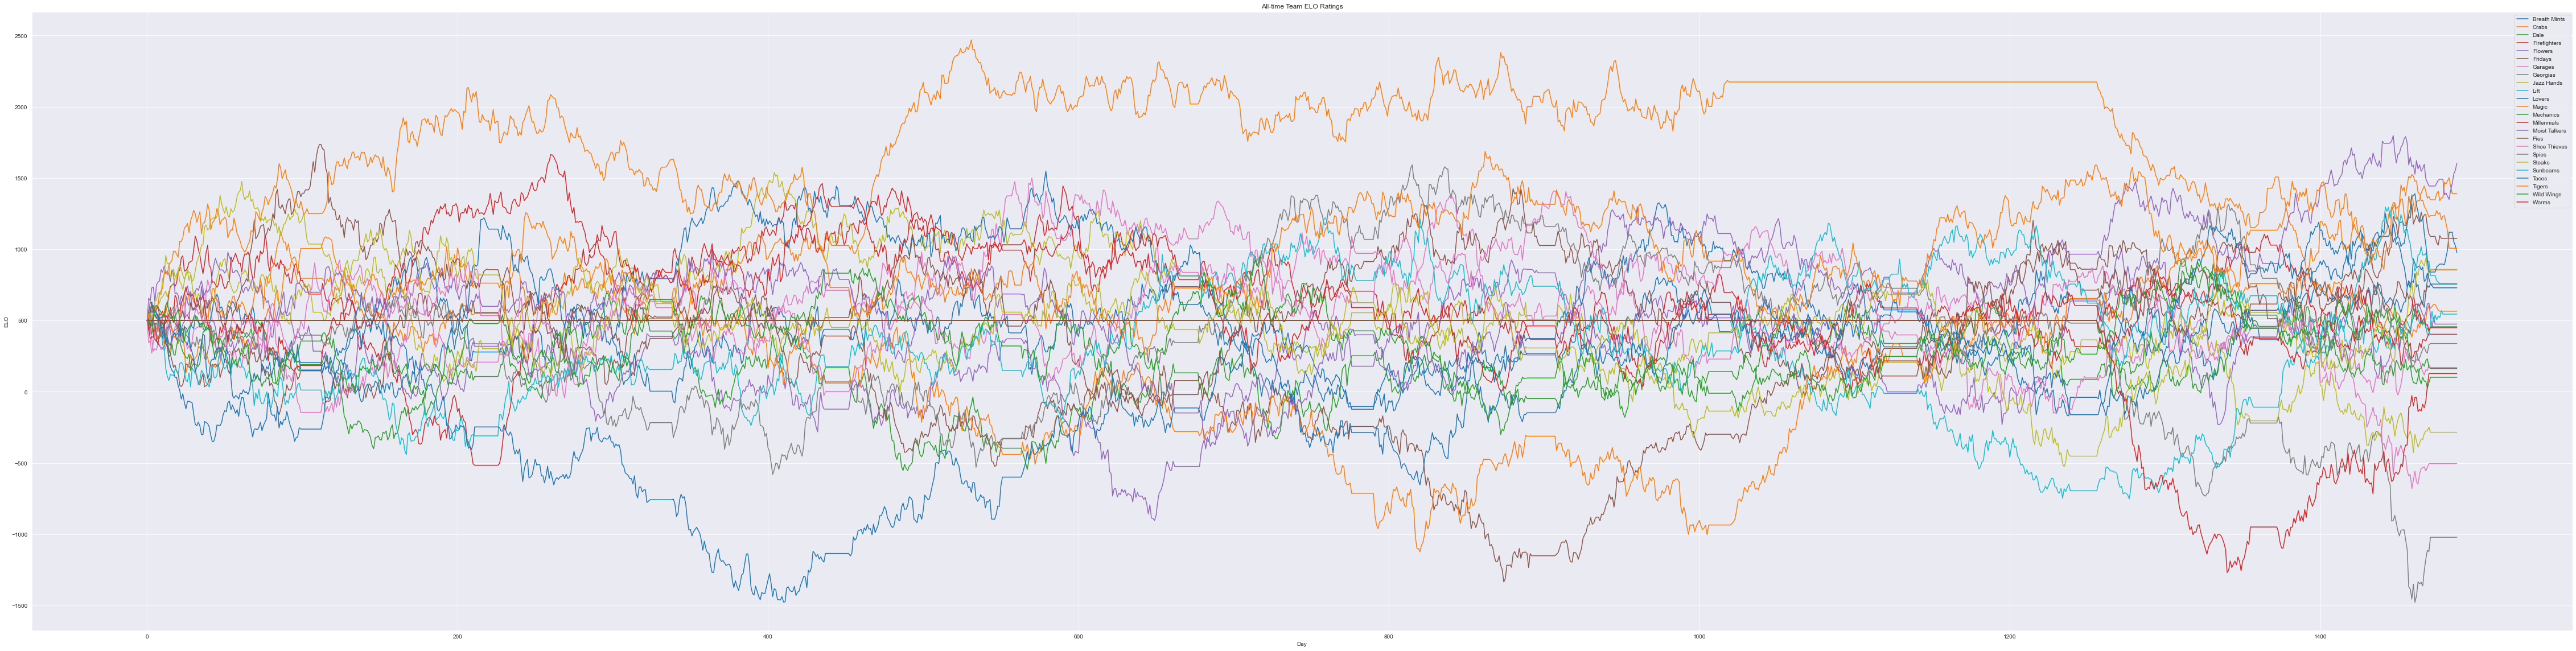

In [58]:
plt.figure(figsize=(80,20))
for i, team in enumerate(teams):
    sns.lineplot(x=new_elo_table.index, y=new_elo_table[team], palette = sns.color_palette(colors,i))
plt.legend(teams, title_fontsize='xx-large')
plt.title('All-time Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

Season 9 Elo Ratings:

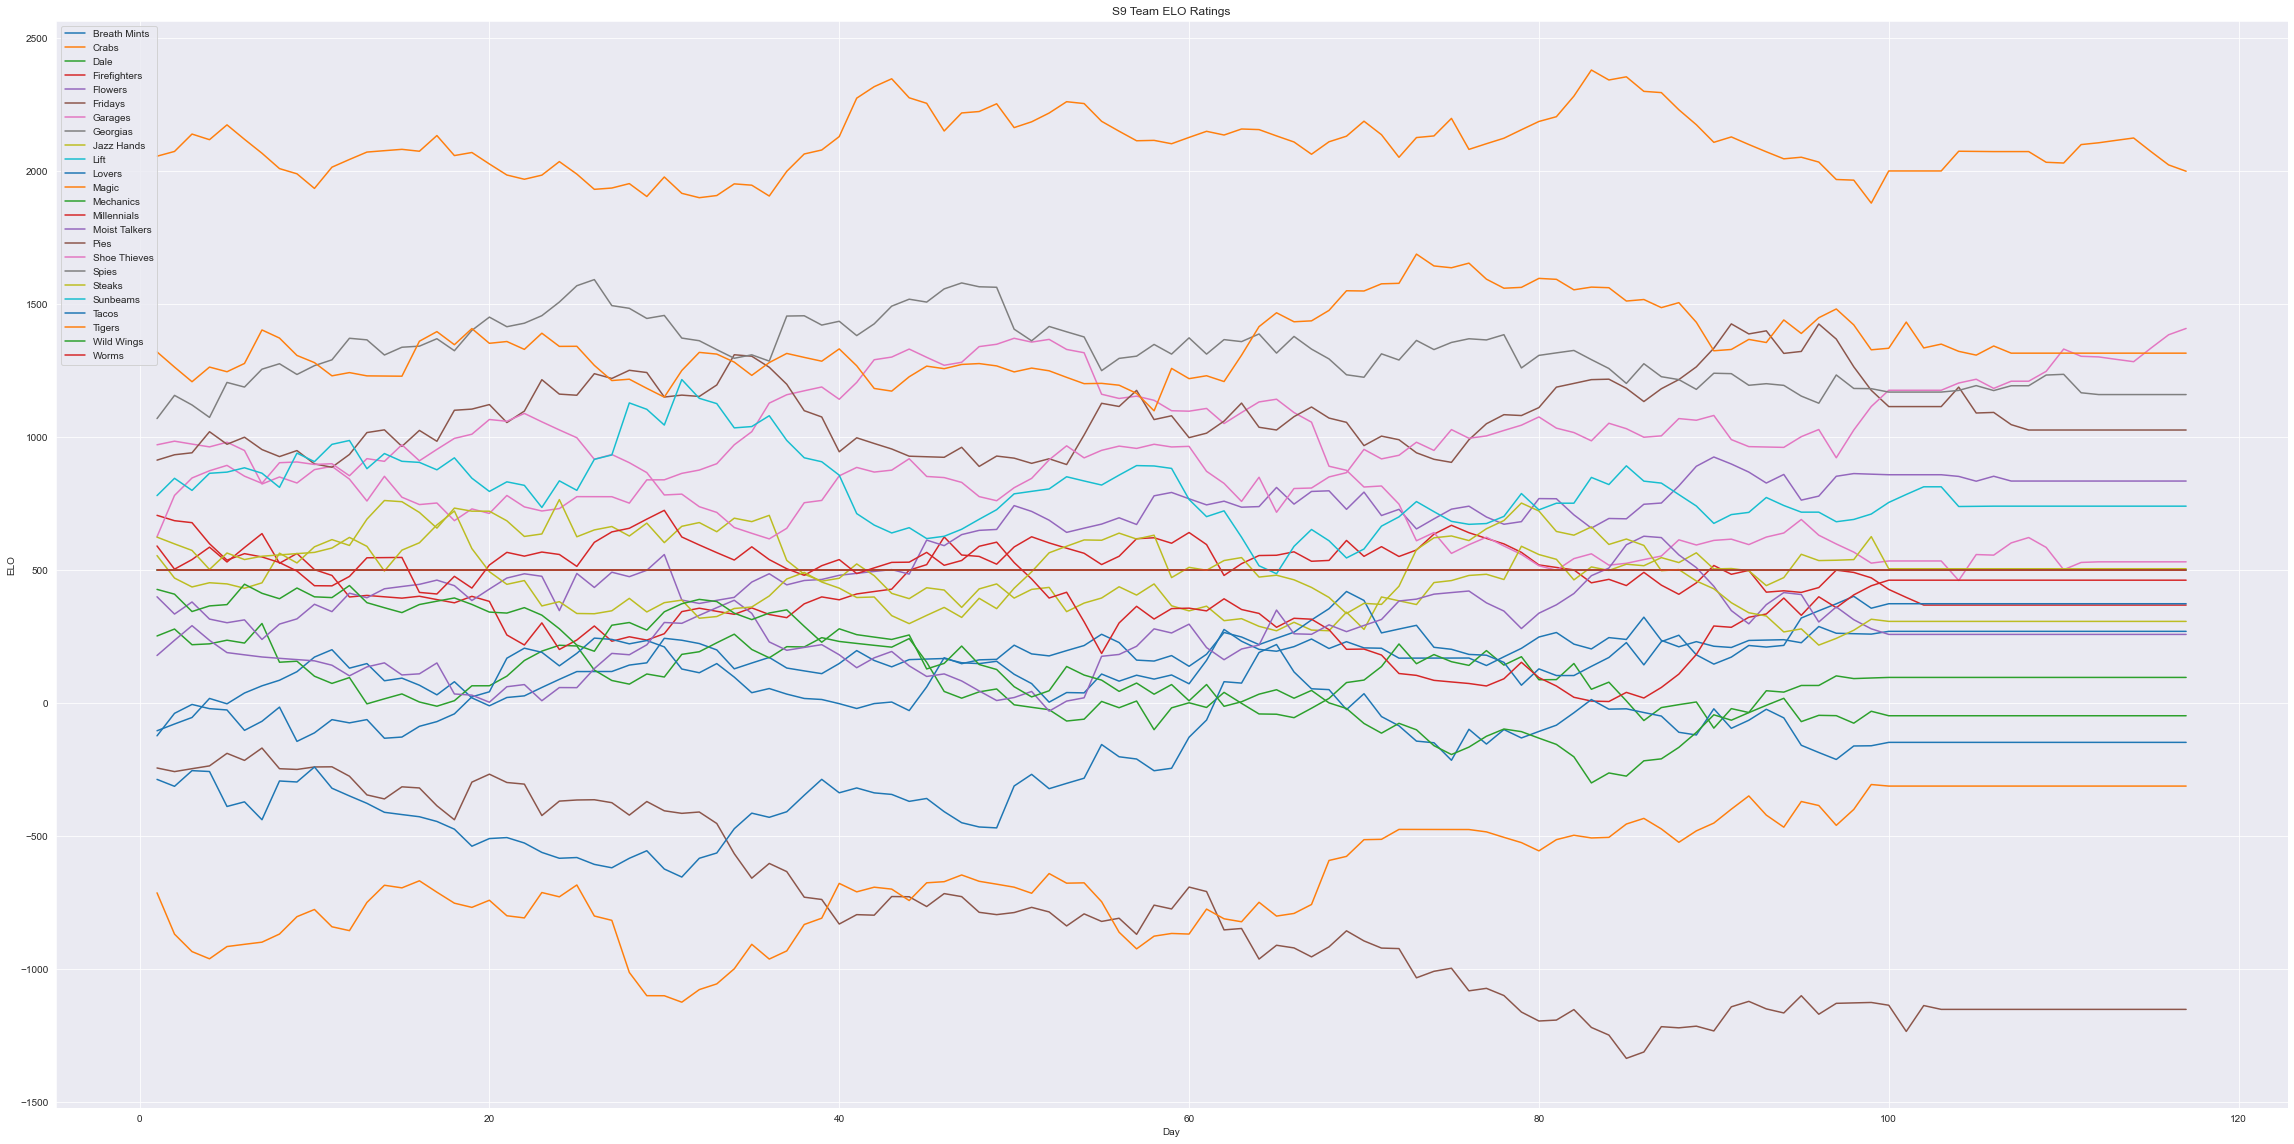

In [59]:
s9_elo = new_elo_table[new_elo_table['season'] == 9]
s9_elo.reset_index(inplace=True,drop=True)
s9_elo.index += 1

plt.figure(figsize=(40,20))
for i, team in enumerate(teams):
    sns.lineplot(x=s9_elo.index, y=s9_elo[team], palette = sns.color_palette(colors,i))
plt.legend(teams, title_fontsize='xx-large')
plt.title('S9 Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

Season 10 ELO Ratings:

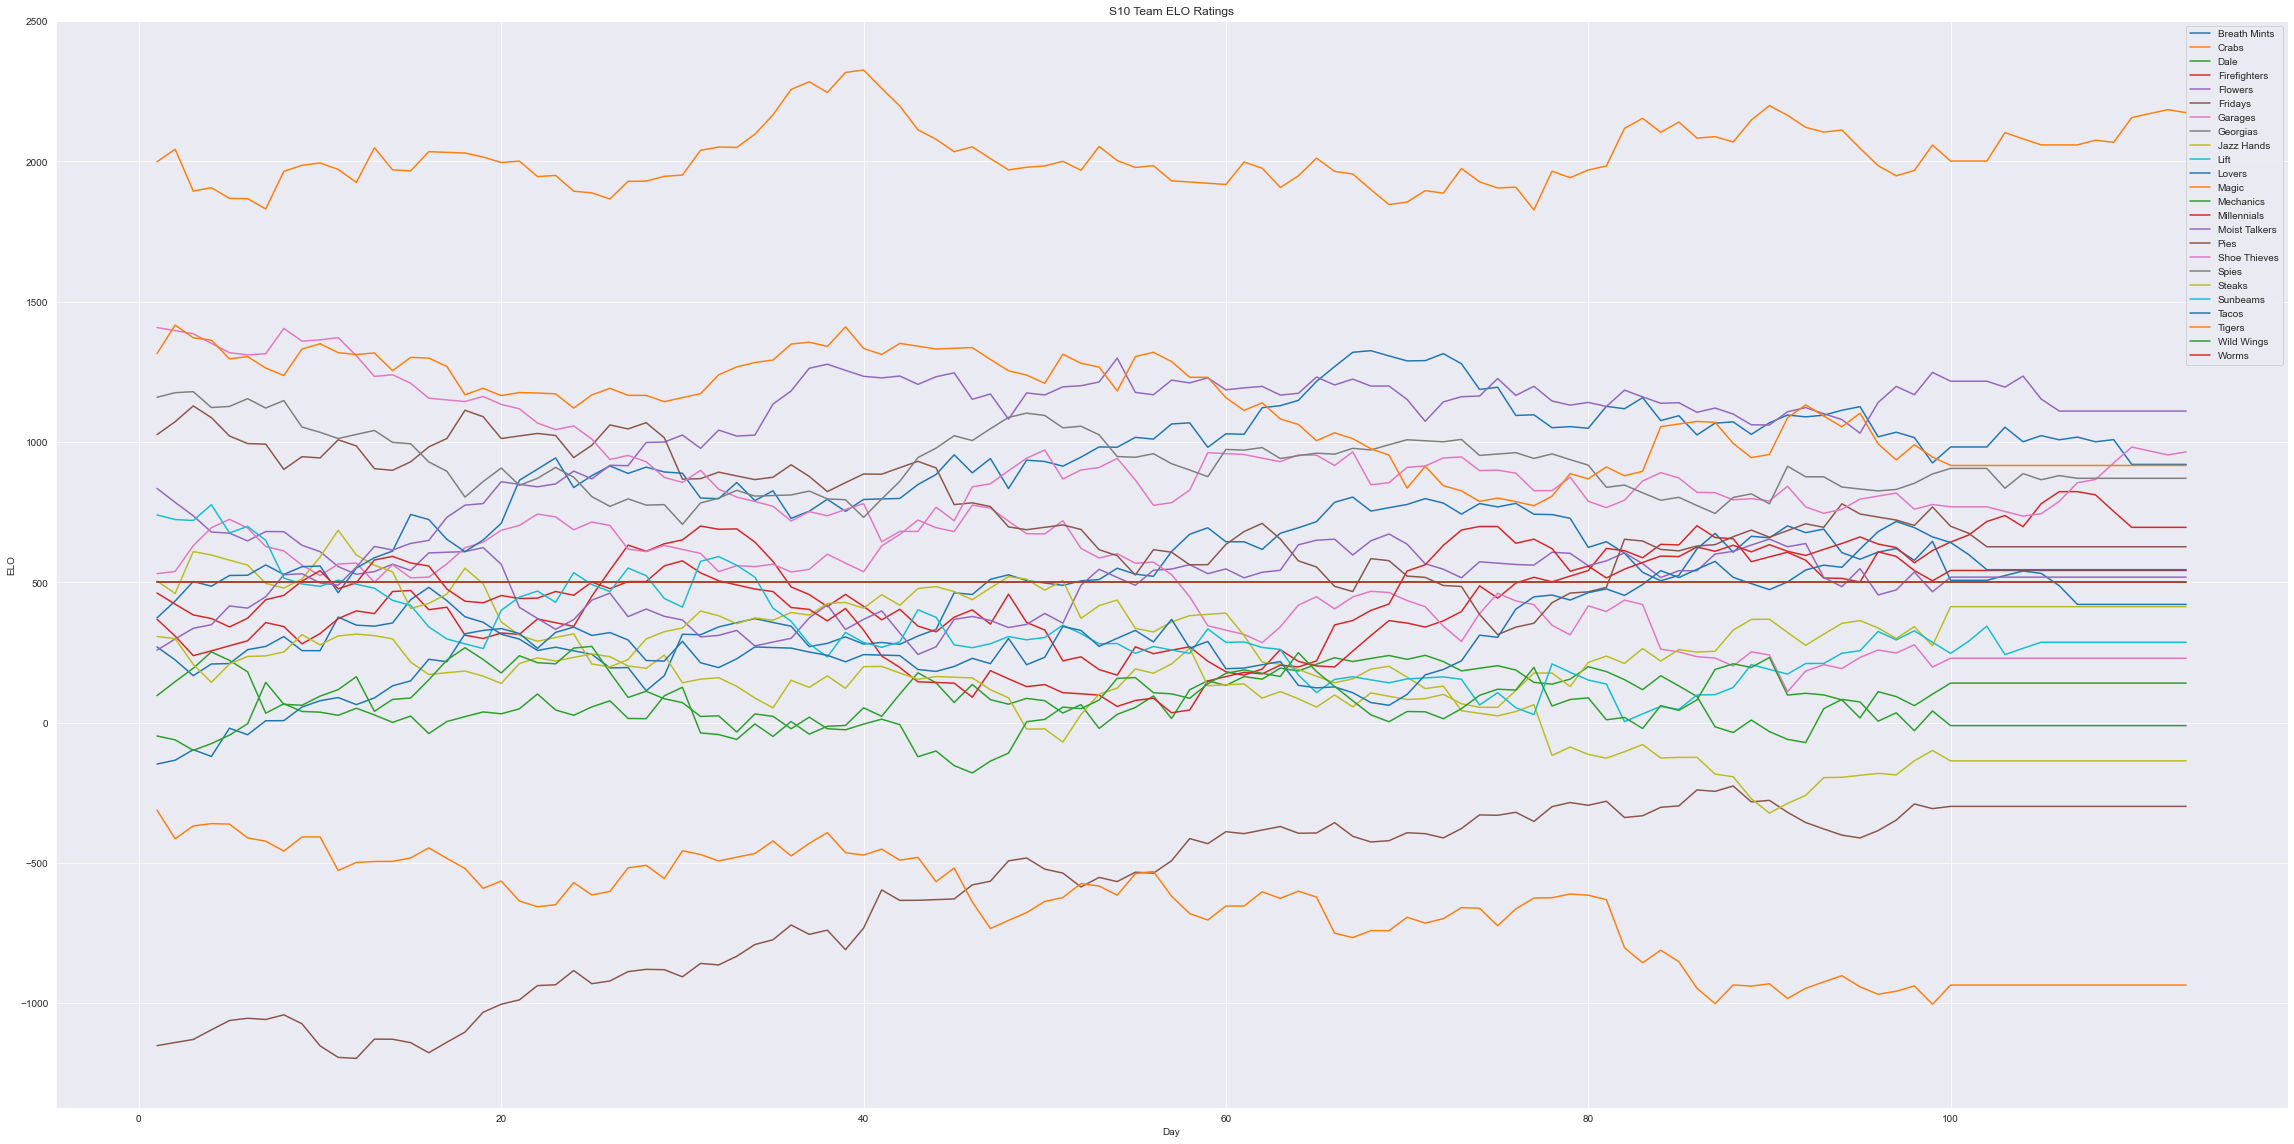

In [60]:
s10_elo = new_elo_table[new_elo_table['season'] == 10]
s10_elo.reset_index(inplace=True,drop=True)
s10_elo.index += 1

plt.figure(figsize=(40,20))
for i, team in enumerate(teams):
    sns.lineplot(x=s10_elo.index, y=s10_elo[team], palette = sns.color_palette(colors,i))
plt.legend(teams, title_fontsize='xx-large')
plt.title('S10 Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

Season 10 Elo Ratings (Current Top 5 Only):

In [61]:
new_elo_table.iloc[-1,3:].sort_values(ascending=False)

incorrect_preds             5817
Moist Talkers            1604.39
Magic                    1390.94
Pies                      1076.7
Tigers                   1007.34
Tacos                    976.152
Steaks                    858.21
Fridays                  854.976
Sunbeams                 760.368
Breath Mints             755.626
Lovers                    729.58
Crabs                    565.222
Lift                     544.892
Flowers                  474.885
Dale                     456.482
Millennials              449.465
Firefighters             403.494
Spies                    338.551
Garages                  170.507
Wild Wings               162.922
Worms                    128.037
Mechanics                101.543
daily_incorrect_preds          0
Jazz Hands              -284.398
Shoe Thieves            -504.815
Georgias                -1021.07
Name: 1488, dtype: object

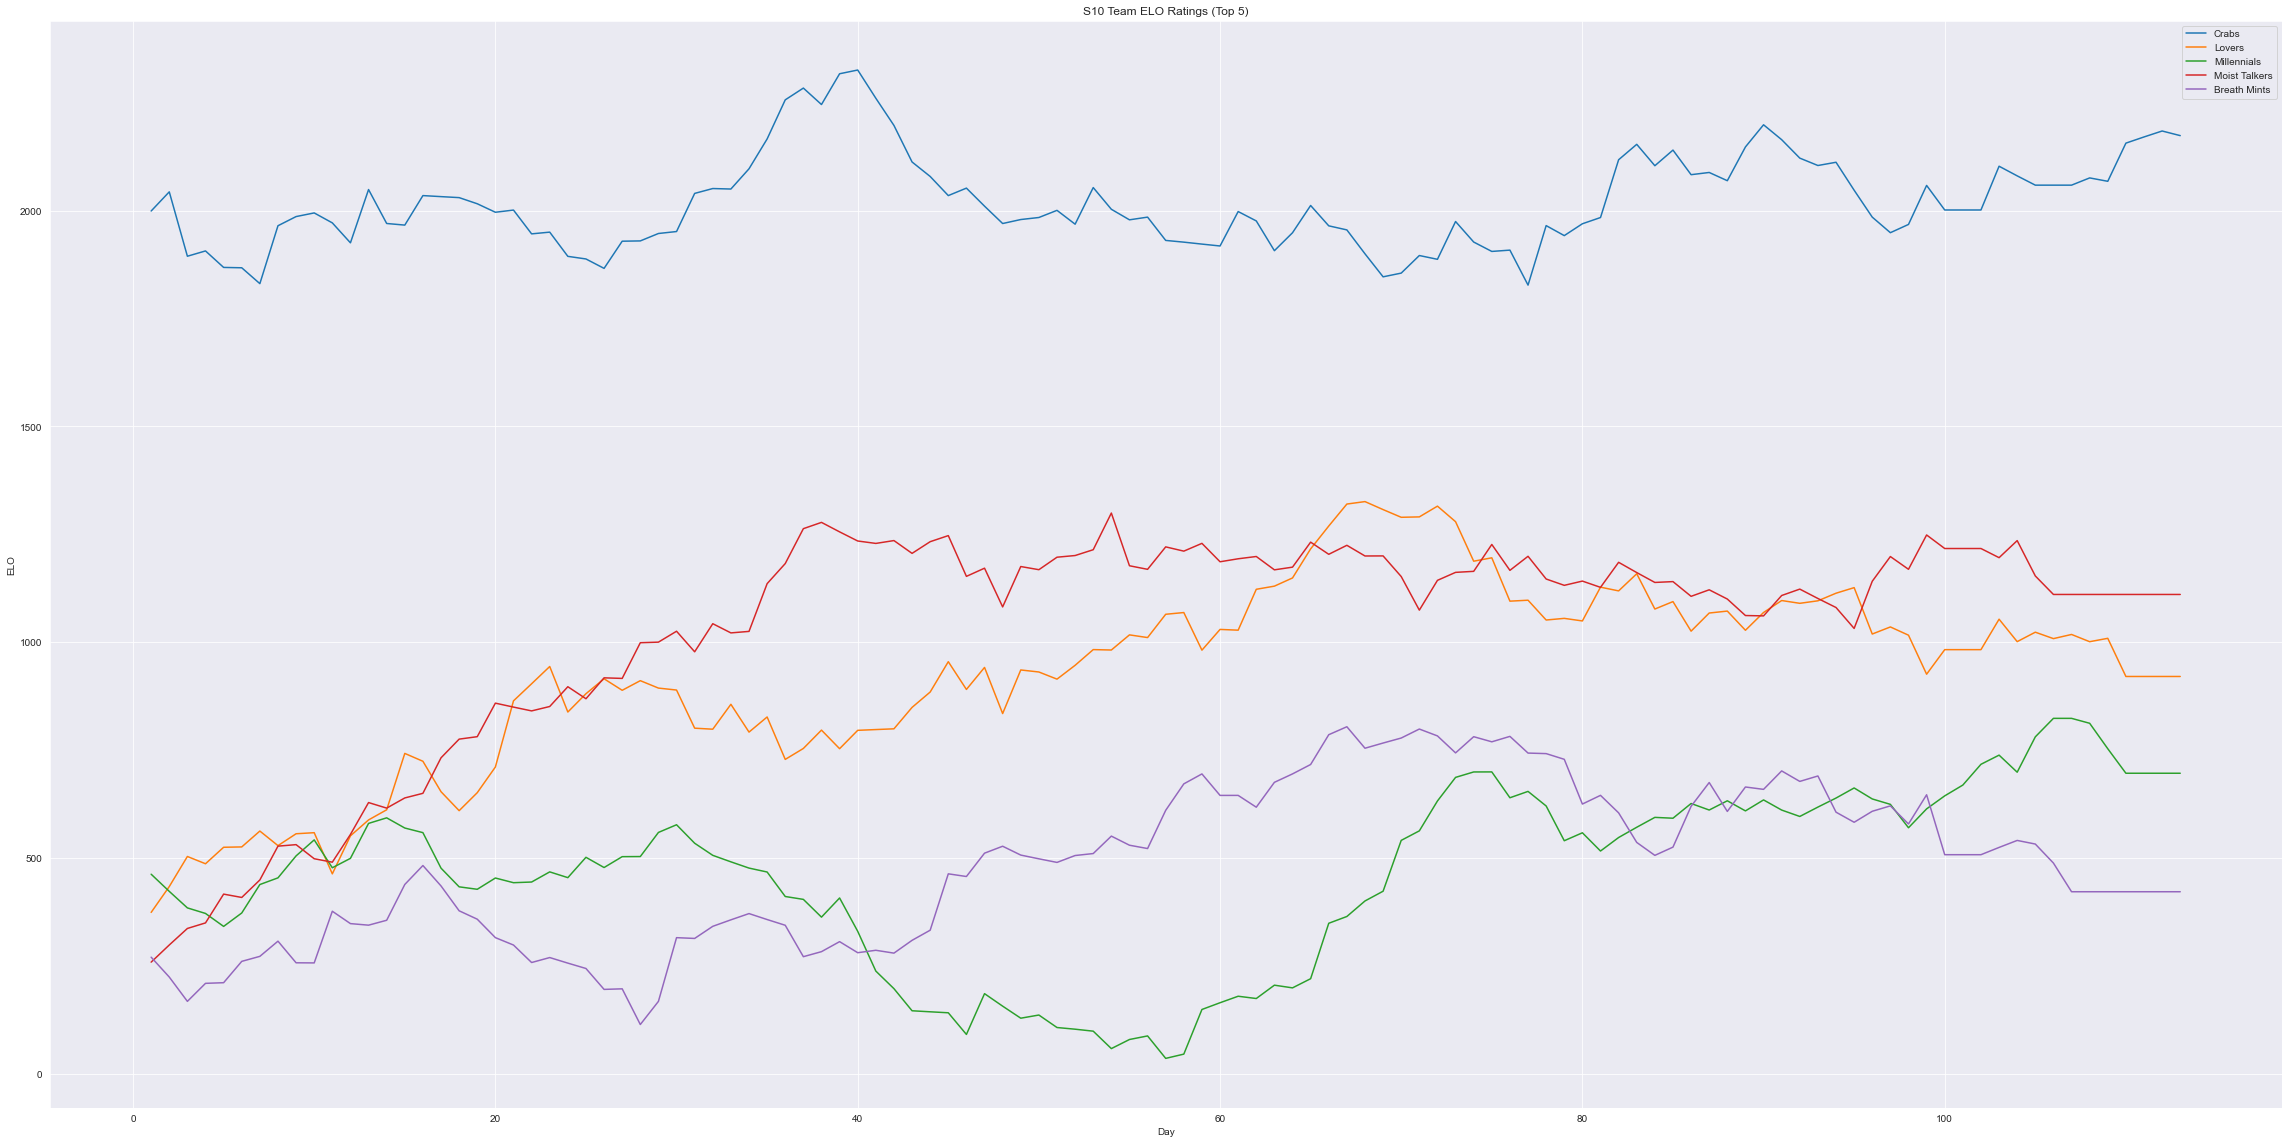

In [62]:
plt.figure(figsize=(40,20))
top5 = ['Crabs','Lovers','Millennials','Moist Talkers','Breath Mints']
for team in top5:
    sns.lineplot(x=s10_elo.index, 
                 y=s10_elo[team], 
                 palette = sns.color_palette(colors,team_color_index[team]))
plt.legend(top5, title_fontsize='xx-large')
plt.title('S10 Team ELO Ratings (Top 5)')
plt.xlabel('Day')
plt.ylabel('ELO');

#### Top teams by mean S10 Elo

In [63]:
s10_elo.describe().transpose()['mean'].sort_values(ascending=False)

incorrect_preds          3650.681416
Crabs                    2019.668363
Tigers                   1120.802236
Moist Talkers            1030.067385
Shoe Thieves              932.693854
Lovers                    928.012751
Spies                     919.205111
Pies                      750.666831
Flowers                   514.026415
Worms                     500.000000
Georgias                  500.000000
Lift                      500.000000
Mechanics                 500.000000
Breath Mints              484.381743
Garages                   464.680192
Millennials               462.419864
Firefighters              435.969744
Sunbeams                  315.839602
Tacos                     311.532254
Steaks                    214.933555
Jazz Hands                200.326866
Wild Wings                 84.374051
Dale                       72.390335
day                        56.097345
season                     10.000000
daily_incorrect_preds       3.743363
Fridays                  -597.407518
M

Season 14 Elo Ratings

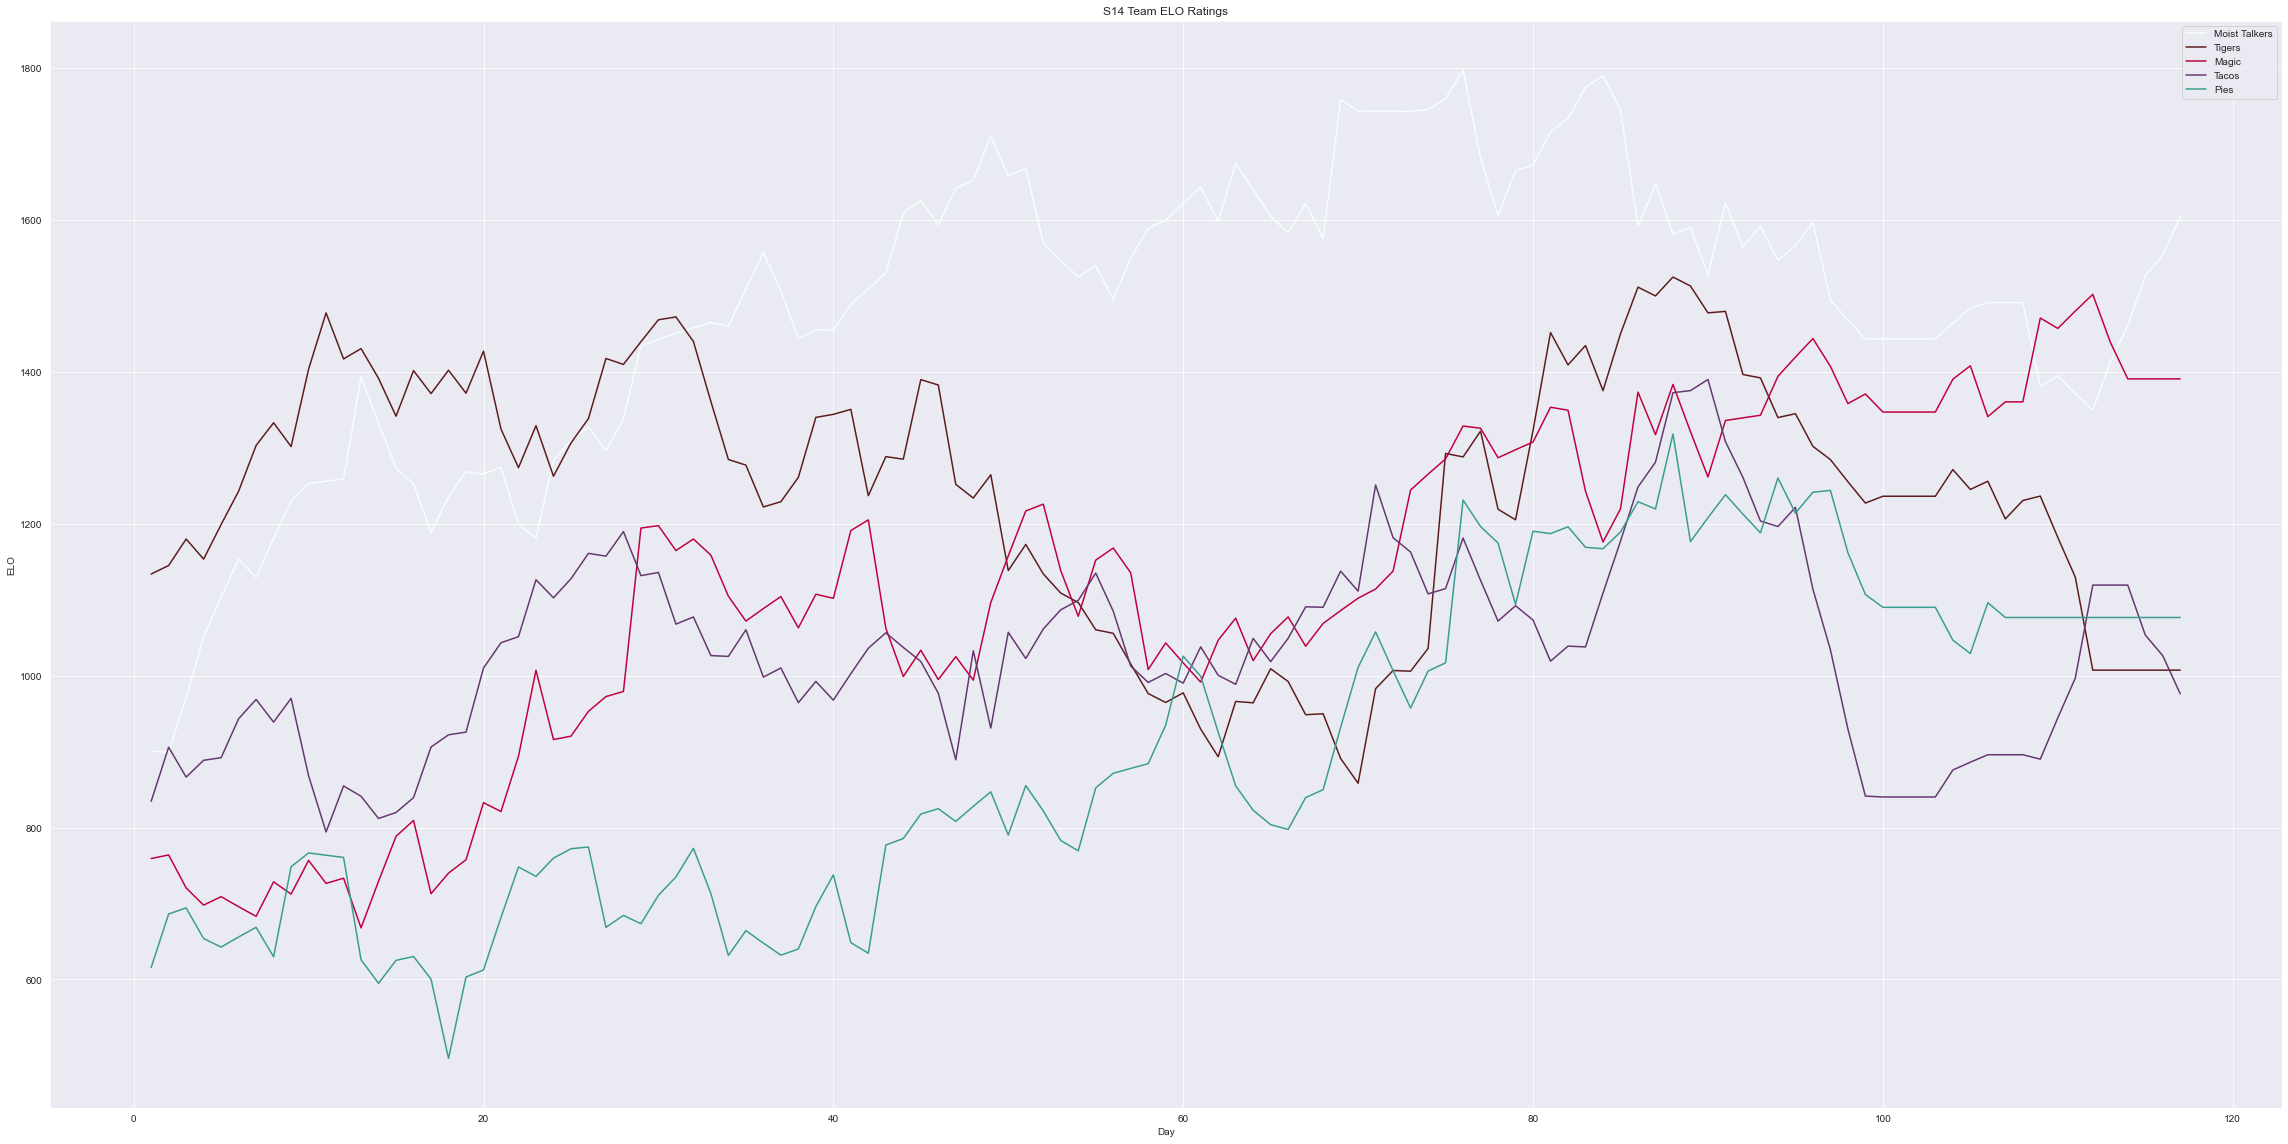

In [113]:
s14_elo = new_elo_table[new_elo_table['season'] == 14]
s14_elo.reset_index(inplace=True,drop=True)
s14_elo.index += 1

plt.figure(figsize=(40,20))
for i, team in enumerate(['Moist Talkers','Tigers','Magic','Tacos','Pies']):
    sns.lineplot(x=s14_elo.index, y=s14_elo[team], color = color_table[color_table['Team'] == team]['Color'].values[0])
plt.legend(['Moist Talkers','Tigers','Magic','Tacos','Pies'], title_fontsize='xx-large')
plt.title('S14 Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

In [112]:
s14_elo[['Magic','Moist Talkers']].tail(20)

Magic  Moist Talkers
98   1358.396760    1468.607505
99   1371.063110    1443.716066
100  1347.261779    1443.743695
101  1347.261779    1443.743695
102  1347.261779    1443.743695
103  1347.261779    1443.743695
104  1390.513963    1464.405928
105  1408.169143    1484.305247
106  1341.172439    1491.469823
107  1360.649460    1491.469823
108  1360.649460    1491.469823
109  1471.064606    1381.054677
110  1457.402884    1394.716399
111  1480.245595    1371.873688
112  1502.244883    1349.874400
113  1439.431889    1412.687394
114  1390.938145    1461.181138
115  1390.938145    1526.870647
116  1390.938145    1554.134697
117  1390.938145    1604.392074

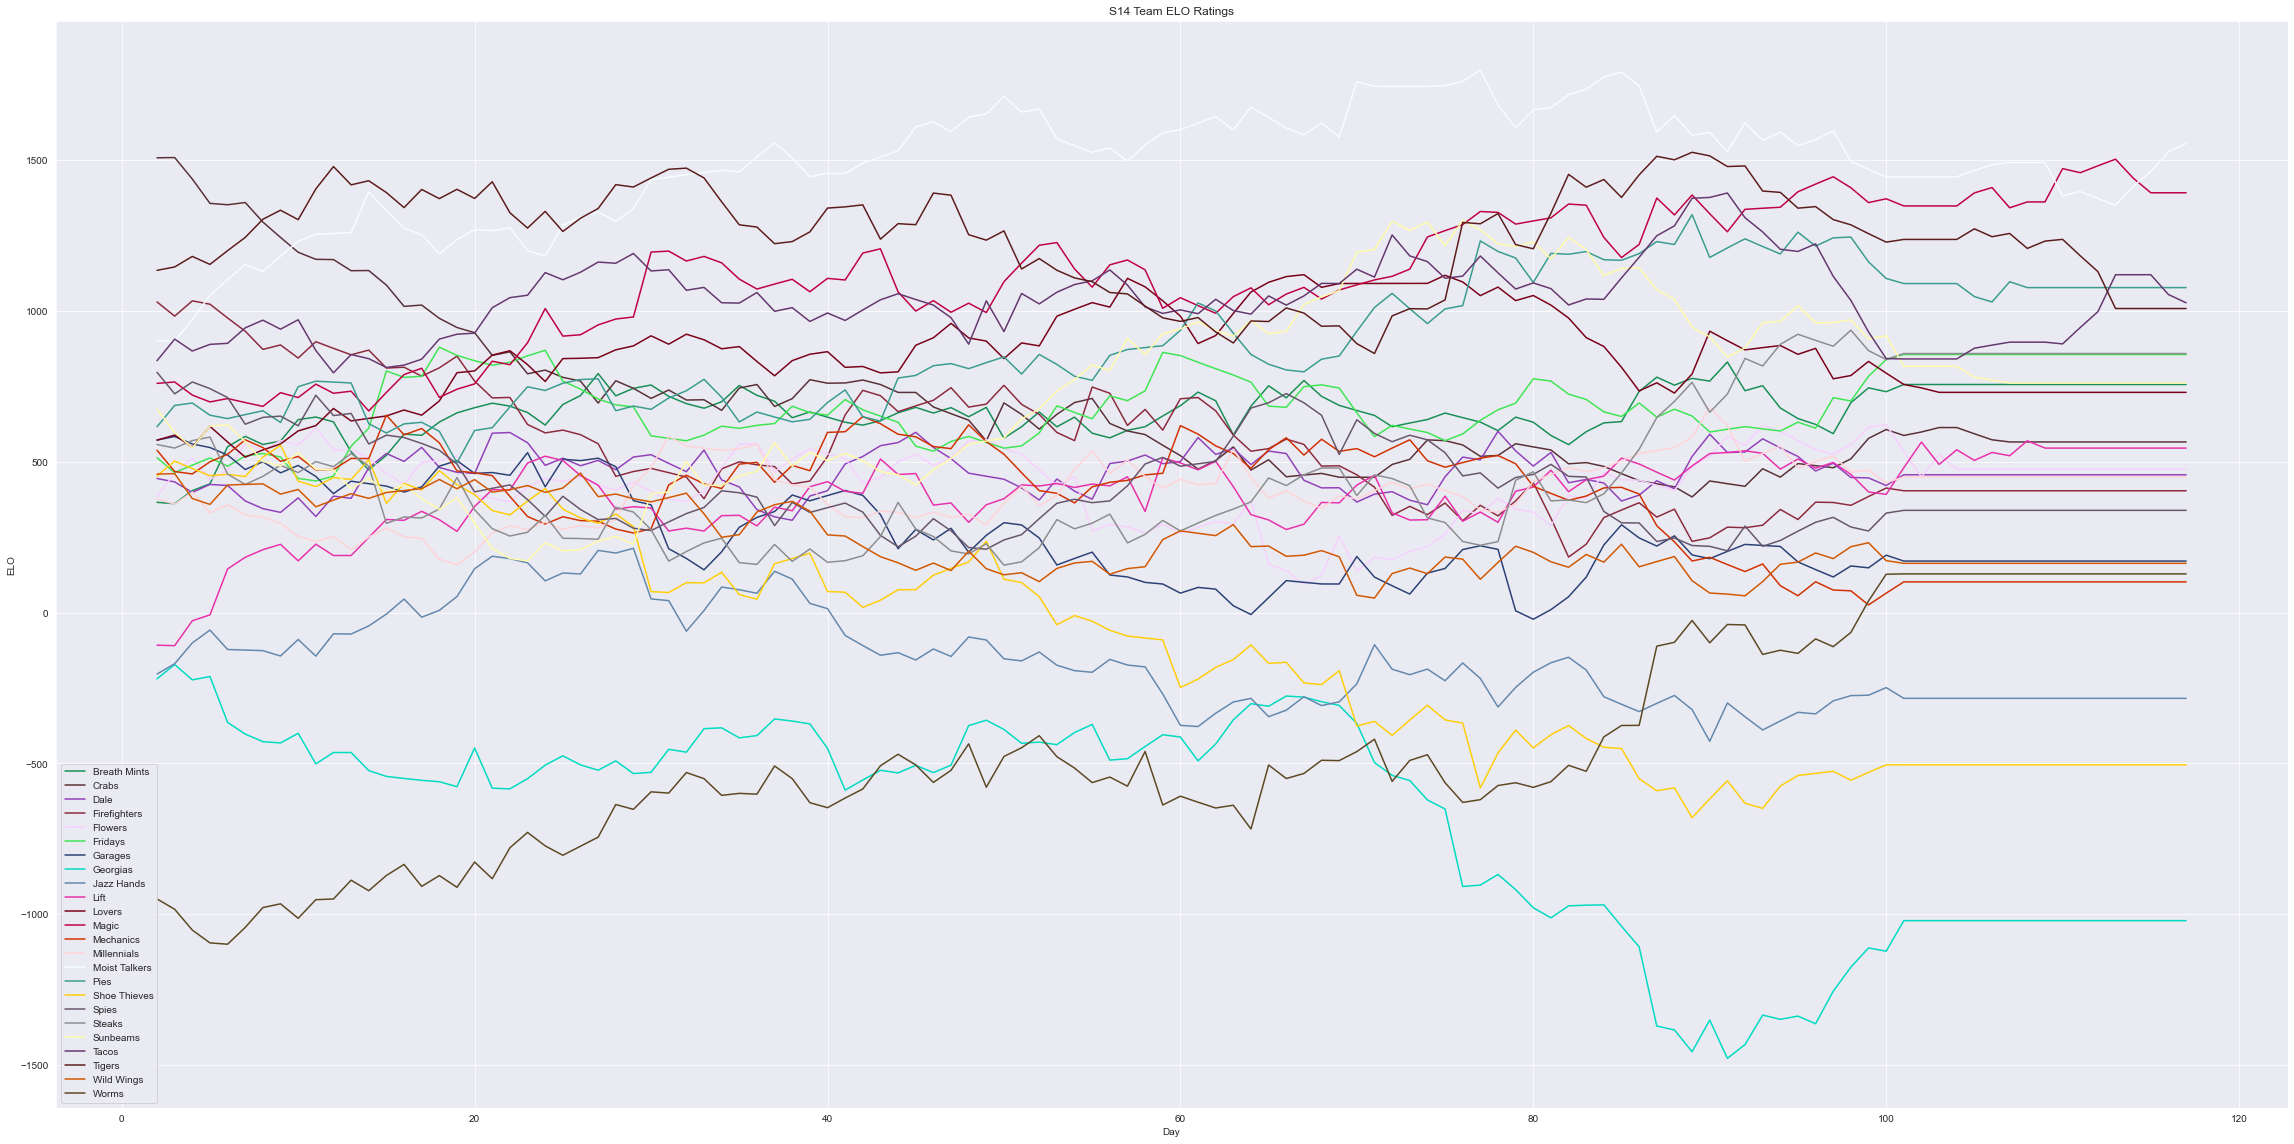

In [111]:
plt.figure(figsize=(40,20))
for i, team in enumerate(teams):
    sns.lineplot(x=pd.Series(s14_elo.index), y=pd.Series(s14_elo[team]), color = color_table[color_table['Team'] == team]['Color'].values[0])
plt.legend(teams, title_fontsize='xx-large')
plt.title('S14 Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

In [70]:
s14_elo.loc[max(s14_elo.index),:].sort_values(ascending=False)

incorrect_preds             5817
Moist Talkers            1604.39
Magic                    1390.94
Pies                      1076.7
Tigers                   1007.34
Tacos                    976.152
Steaks                    858.21
Fridays                  854.976
Sunbeams                 760.368
Breath Mints             755.626
Lovers                    729.58
Crabs                    565.222
Lift                     544.892
Flowers                  474.885
Dale                     456.482
Millennials              449.465
Firefighters             403.494
Spies                    338.551
Garages                  170.507
Wild Wings               162.922
Worms                    128.037
day                          117
Mechanics                101.543
season                        14
is_postseason               True
daily_incorrect_preds          0
Jazz Hands              -284.398
Shoe Thieves            -504.815
Georgias                -1021.07
Name: 117, dtype: object

In [65]:
s14_elo.describe().transpose()['mean'].sort_values(ascending=False)

incorrect_preds          5588.649573
Moist Talkers            1484.032372
Tigers                   1240.431804
Magic                    1123.128547
Tacos                    1033.360224
Pies                      903.128942
Lovers                    847.271425
Sunbeams                  736.100772
Crabs                     691.830231
Fridays                   691.295666
Breath Mints              666.235675
Firefighters              543.861161
Steaks                    471.449256
Dale                      464.001385
Flowers                   432.553336
Spies                     417.828555
Millennials               406.139627
Lift                      390.161652
Mechanics                 381.491903
Garages                   252.786913
Wild Wings                239.602197
day                        58.076923
season                     14.000000
daily_incorrect_preds       4.435897
Shoe Thieves             -107.161854
Jazz Hands               -158.622876
Worms                    -464.125045
G

S13 Elo

In [66]:
s13_elo = new_elo_table[new_elo_table['season'] == 13]
s13_elo.reset_index(inplace=True,drop=True)
s13_elo.index += 1
s13_elo.describe().transpose()['mean'].sort_values(ascending=False)

incorrect_preds          5063.741379
Crabs                    1518.036730
Moist Talkers            1153.956421
Tigers                   1136.651644
Spies                     911.710549
Fridays                   850.834078
Magic                     776.774030
Firefighters              715.792347
Tacos                     694.913767
Wild Wings                636.409715
Pies                      613.810465
Millennials               594.478044
Sunbeams                  553.537363
Garages                   533.848441
Dale                      475.563623
Flowers                   464.054383
Breath Mints              386.339336
Shoe Thieves              372.350659
Lovers                    270.556302
Steaks                    241.928383
Mechanics                 229.746582
Jazz Hands                211.374562
day                        57.568966
season                     13.000000
daily_incorrect_preds       4.525862
Georgias                 -232.159570
Lift                     -431.835766
W